In [1]:
import gym 
from gym import error, spaces, utils
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import math

import random
from gym.utils import seeding

### Goldmining environment

In [2]:
class GoldMining(gym.Env):
    
    def __init__(self, width, height, max_steps = 200, gold_mines = 4, full_grid=False):
        self.height = height
        self.width = width
        self.max_steps = max_steps
        self._max_episode_steps = max_steps
        self.gold_mines = gold_mines
        self.current_steps = 0
        self.mines_left = self.gold_mines
        self.EMPTY = 0
        self.GOLD  = 1
        self.AGENT = 2
        self.full_grid = full_grid

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.width),
                spaces.Discrete(self.height)
                ))
        self.reset()

    def checkAction(self, action):
        if action == 0:
            return "UP"
        elif action == 1:
            return "DOWN"
        elif action == 2:
            return "LEFT"
        return "RIGHT"

    def reset(self):
        #Initialize all cells to empty
        self.grid = [[0 for i in range(self.height)] for j in range(self.width)]
        #Set the agent to (0,0) starting position
        self.grid[0][0] = self.AGENT
        self.state = [0,0]
        #Reset the current time step
        self.current_steps = 0
        self.mines_left = self.gold_mines

        #Storing goldmine locations and respective rewards
        self.loc_reward = [[0, 0, 0] for i in range(self.gold_mines)] #(i, j, r)

        #Setup the gold mines                
        goldmine_count = -1
        gold_list_1 = [1,1.1,1.2,1.3,1.4,1.5,2,2.1,7.2,9,0,0]
        for g in range(len(gold_list_1)):
            goldmine_count += 1
            self.grid[g][2] = gold_list_1[g]
            self.loc_reward[goldmine_count] = [g, 2, gold_list_1[g]]
                    
        gold_list_2 = [-1,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8]
        for g in range(len(gold_list_2)):
            goldmine_count += 1
            self.grid[g][1] = gold_list_2[g]
            self.loc_reward[goldmine_count] = [g, 1, gold_list_2[g]]
                    
        gold_list_3 = [-1,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,6]
        for g in range(len(gold_list_3)):
            goldmine_count += 1
            self.grid[g+1][0] = gold_list_3[g]
            self.loc_reward[goldmine_count] = [g+1, 0, gold_list_3[g]]
   
        #print("Displaying grid at reset: \n", np.flip(np.transpose(np.array(self.grid)), axis=0))
                
        if self.full_grid:
            return np.array(self.grid).flatten()

        return self.get_observation(self.state)

    def findReward(self, a, b):
        #Given the location find if its respective reward or return -1
        for i in range(self.gold_mines):
            if self.loc_reward[i][0] == a and self.loc_reward[i][1] == b:
                return self.loc_reward[i][2]
        return -1

    def findRewardLocation(self, a, b):
        #Given the location, return the index of the gold mine
        for i in range(self.gold_mines):
            if self.loc_reward[i][0] == a and self.loc_reward[i][1] == b:
                return i
        return -1

    def step(self, action):
        self.current_steps = self.current_steps + 1 
        
        a, b = self.state[0], self.state[1]

        if self.checkAction(action) == "UP":
            #check if reached the end of the grid from top
            if (b+1) == self.height:
                #return the current state with reward -1
                if self.full_grid:
                    return np.array(self.grid).flatten(), -1, self.isTerminal(), None
                return self.get_observation(self.state), -1, self.isTerminal(), None
            else:
                #Move up
                self.grid[a][b]   = self.EMPTY
                self.grid[a][b+1] = self.AGENT
                #update b
                b = b + 1
                self.state[1] = b

        elif self.checkAction(action) == "DOWN":
            #check if reached the end of the grid from bot
            if (b-1) < 0:
                #return the current state with reward -1
                if self.full_grid:
                    return np.array(self.grid).flatten(), -1, self.isTerminal(), None
                return self.get_observation(self.state), -1, self.isTerminal(), None
            else:
                #Move down
                self.grid[a][b]   = self.EMPTY
                self.grid[a][b-1] = self.AGENT
                #update b
                b = b - 1
                self.state[1] = b

        elif self.checkAction(action) == "LEFT":
            #check if reached the end of the grid from left
            if (a-1) < 0:
                #return the current state with reward -1
                if self.full_grid:
                    return np.array(self.grid).flatten(), -1, self.isTerminal(), None
                return self.get_observation(self.state), -1, self.isTerminal(), None
            else:
                #Move down
                self.grid[a][b]   = self.EMPTY
                self.grid[a-1][b] = self.AGENT
                #update a
                a = a - 1
                self.state[0] = a

        else:
            #check if reached the end of the grid from right
            if (a+1) == self.width:
                #return the current state with reward -1
                if self.full_grid:
                    return np.array(self.grid).flatten(), -1, self.isTerminal(), None
                return self.get_observation(self.state), -1, self.isTerminal(), None
            else:
                #Move down
                self.grid[a][b]   = self.EMPTY
                self.grid[a+1][b] = self.AGENT
                #update a
                a = a + 1
                self.state[0] = a

        #Rewards (and their locations) are updated once consumed
        r = self.findReward(a, b)
        #Update the rewards since consumed
        if r > 0:
            i = self.findRewardLocation(a, b)
            self.loc_reward[i][2] = -1
            self.mines_left -=1 

        #Convering the state to a 100 dimensional vector
        if self.full_grid:
            return np.array(self.grid).flatten(), r, self.isTerminal(), None #would be a normal 2D return later
        return self.get_observation(self.state), r, self.isTerminal(), None #would be a normal 2D return later

    def findAgent(self):
        #Find the index of agent's location
        for i in range(self.width):
            for j in range(self.height):
                if self.grid[i][j] == self.AGENT:
                    return i, j

    def isTerminal(self):
        if self.current_steps == self.max_steps:
            return True
        #Otherwise check if all gold pots collected
        if self.mines_left == 0:
            return True
        return False

    def render(self, mode='human'):
        print("Current Grid Snapshot: ")
        print("0 denotes EMPTY")
        print("1 denotes GOLD")
        print("2 denotes AGENT")
        for i in range(self.width):
            print(self.grid[i])
            
    def get_observation(self, state):
        return state[1]*self.width + state[0] 

### Learning

#### Helper functions

In [3]:
# add arrows to show learned policy
def policy_viz(policy, action_dict):
    policy = policy.astype(str)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            policy[i][j] = action_dict[int(policy[i][j])]
    return policy

In [4]:
# smoothen curves
def smoothen_curves(frames, returns, window_width=30):
    frames = np.array(frames)
    returns = np.array(returns)
    cumsum_vec = np.cumsum(np.insert(returns, 0, 0)) 
    returns = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    cumsum_vec = np.cumsum(np.insert(frames, 0, 0)) 
    frames = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return frames, returns

#### Hyperparameters

In [5]:
factor = 10

experiment = {'w': 12, 'h': 3, 'ts': 11, 'gms': 35}
env = GoldMining(width = experiment['w'], height = experiment['h'], max_steps = experiment['ts'], gold_mines = experiment['gms'])
action_dict = {0:'>', 1:'<', 2:'^', 3:'v'}
action_dict_flipped = {0:'^', 1:'v', 2:'<', 3:'>'}

num_episodes = 100000
num_actions = 4
gamma = 0.99
alpha = 0.001

#setting the seed for reproducibility
np.random.seed(0)

#### Q-learning

In [6]:
# q-learning

q_returns_over_runs = []
q_max_rewards_over_runs = []
q_final_policy_over_runs = []
q_final_q_values_over_runs = []
num_runs = 10

for run in range(num_runs):
    print("Run = ", str(run))
    q = np.zeros((experiment['w']*experiment['h'],num_actions))
    episode_returns = []
    episode_max_rewards = []
    epsilon_schedule = np.concatenate((np.linspace(0.2,0,int(num_episodes*experiment['ts']/2)),np.array([0]*(int(num_episodes*experiment['ts']/2)+1))))
    timesteps = 0

    for episode in range(num_episodes):
        obs = env.reset()
        episode_return = 0
        episode_max_reward = -100
        done = False
        while done != True:
            timesteps += 1
            prev_obs = deepcopy(obs)
            a = np.argmax(q[obs])
            if np.random.rand()<epsilon_schedule[timesteps]:
                #if np.random.rand()<0.1:
                a = np.random.randint(num_actions)
                #print("random action taken")
            obs, r, done, info = env.step(a)
            q[prev_obs,a] = q[prev_obs,a] + alpha*(r+gamma*max(q[obs]) - q[prev_obs,a])
            episode_return += r
            episode_max_reward = max(r, episode_max_reward)
            #print(prev_obs,action_dict[a])

        episode_returns.append(episode_return)
        episode_max_rewards.append(episode_max_reward)
        #if episode%1000==0:
        #    print("Episode ", str(episode), " ended with return = ", str(episode_return))
        #    policy = np.reshape(np.argmax(q,axis=1), (-1, experiment['w']))
        #    print("Policy: \n", policy_viz(np.transpose(policy), action_dict))

    policy = np.reshape(np.argmax(q,axis=1), (-1, experiment['w']))
    print("Final policy: \n", np.flip(policy_viz(policy, action_dict_flipped), axis=0))
    q_final_policy_over_runs.append(np.flip(policy_viz(policy, action_dict_flipped), axis=0))
    #print("Final policy: \n", policy_viz(np.transpose(policy), action_dict))
    print("Final q values: \n", q)
    q_final_q_values_over_runs.append(q)

    episodes, returns = smoothen_curves(np.arange(0,num_episodes,1), episode_returns)
    q_returns_over_runs.append(returns)
    
    dummy, max_rewards = smoothen_curves(np.arange(0,num_episodes,1), episode_max_rewards)
    q_max_rewards_over_runs.append(max_rewards)
    
    #plt.plot(episodes, returns, label = 'q')
    #plt.legend()
    #plt.ylim(min(returns)-10,max(returns)+10)
    #plt.show()

Run =  0
Final policy: 
 [['>' '>' '>' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '^' '^' 'v' '^' '^' '^' '^' '^' '^' '^' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '^']]
Final q values: 
 [[ 8.09036469e-02  1.35274642e+01  1.31831430e+01  2.57734157e+01]
 [-4.79513409e+00  1.43951295e+01  1.32132624e+01  2.70438542e+01]
 [-4.33582222e+00  1.35214651e+01  1.35774775e+01  2.51958124e+01]
 [-8.10287667e-01  1.23937100e+01  1.35442247e+01  2.32280933e+01]
 [-3.54111488e+00  1.14774404e+01  1.22494169e+01  2.11394882e+01]
 [-3.05136556e+00  9.79468946e+00  1.11154142e+01  1.89287759e+01]
 [-2.52132158e+00  8.23015905e+00  9.41751915e+00  1.65947232e+01]
 [-2.41723410e+00  6.76520510e+00  8.11584923e+00  1.41360840e+01]
 [-2.52408229e+00  5.17808221e+00  6.69091359e+00  1.15516000e+01]
 [-2.92465363e+00  3.06348534e+00  4.43947904e+00  8.84000000e+00]
 [-2.94077966e+00  1.63024814e+00  2.63544733e+00  6.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

Final policy: 
 [['>' '>' '>' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '^' 'v' 'v' 'v' 'v' '^' '^' '^' '^' '^' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '^']]
Final q values: 
 [[ 6.93193308e-02  1.30573810e+01  1.30819577e+01  2.57734157e+01]
 [-4.91204256e+00  1.44759712e+01  1.35265531e+01  2.70438542e+01]
 [-9.00384260e-02  1.36321081e+01  1.48259652e+01  2.51958124e+01]
 [-3.30763175e-01  1.26291317e+01  1.35601753e+01  2.32280933e+01]
 [-7.53384204e-01  1.13337025e+01  1.27010708e+01  2.11394882e+01]
 [-1.25097122e+00  1.03435957e+01  1.12948911e+01  1.89287759e+01]
 [-3.61040779e+00  8.77595754e+00  1.00791757e+01  1.65947232e+01]
 [-2.99316272e+00  7.06798538e+00  8.40597920e+00  1.41360840e+01]
 [-2.75343211e+00  5.59024932e+00  6.53973551e+00  1.15516000e+01]
 [-2.98119275e+00  3.41227671e+00  4.29526600e+00  8.84000000e+00]
 [-3.03604460e+00  1.66698490e+00  2.42798880e+00  6.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.884

Final policy: 
 [['>' '>' '>' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '^' 'v' 'v' '^' '^' '^' '^' '^' '^' '^' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '^']]
Final q values: 
 [[ 5.45468032e-02  1.36331077e+01  1.37195404e+01  2.57734157e+01]
 [-4.96148101e+00  1.43854437e+01  1.29544273e+01  2.70438542e+01]
 [-2.08894699e-02  1.34241507e+01  1.41917547e+01  2.51958124e+01]
 [-7.74400332e-01  1.27380523e+01  1.39260078e+01  2.32280933e+01]
 [-3.97743155e+00  1.11924902e+01  1.25462052e+01  2.11394882e+01]
 [-3.39309501e+00  9.88424153e+00  1.12480961e+01  1.89287759e+01]
 [-2.96022286e+00  8.60810364e+00  9.37904033e+00  1.65947232e+01]
 [-2.66126707e+00  6.89650935e+00  8.30342006e+00  1.41360840e+01]
 [-2.59611852e+00  5.21299927e+00  6.65852612e+00  1.15516000e+01]
 [-2.95334023e+00  3.23865532e+00  4.36834833e+00  8.84000000e+00]
 [-2.78662521e+00  1.64456675e+00  2.40430977e+00  6.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.887

#### Max-Q

In [7]:
# max q-learning

max_q_returns_over_runs = []
max_q_max_rewards_over_runs = []
max_q_final_policy_over_runs = []
max_q_final_q_values_over_runs = []
num_runs = 10

for run in range(num_runs):
    print("Run = ", str(run))
    q = np.zeros((experiment['w']*experiment['h'],num_actions))
    episode_returns = []
    episode_max_rewards = []
    epsilon_schedule = np.concatenate((np.linspace(0.2,0,int(num_episodes*experiment['ts']/2)),np.array([0]*(int(num_episodes*experiment['ts']/2)+1))))
    timesteps = 0

    for episode in range(num_episodes):
        obs = env.reset()
        episode_return = 0
        episode_max_reward = -100
        done = False
        while done != True:
            timesteps += 1
            prev_obs = deepcopy(obs)
            a = np.argmax(q[obs])
            if np.random.rand()<epsilon_schedule[timesteps]:
                #if np.random.rand()<0.1:
                a = np.random.randint(num_actions)
                #print("random action taken")
            obs, r, done, info = env.step(a)
            q[prev_obs,a] = q[prev_obs,a] + alpha*(max(r,gamma*max(q[obs])) - q[prev_obs,a])
            episode_return += r
            episode_max_reward = max(r, episode_max_reward)
            #print(prev_obs,action_dict[a])

        episode_returns.append(episode_return)
        episode_max_rewards.append(episode_max_reward)
        #if episode%1000==0:
        #    print("Episode ", str(episode), " ended with return = ", str(episode_return))
        #    policy = np.reshape(np.argmax(q,axis=1), (-1, experiment['w']))
        #    print("Policy: \n", policy_viz(np.transpose(policy), action_dict))
        
    policy = np.reshape(np.argmax(q,axis=1), (-1, experiment['w']))    
    print("Final policy: \n", np.flip(policy_viz(policy, action_dict_flipped), axis=0))
    max_q_final_policy_over_runs.append(np.flip(policy_viz(policy, action_dict_flipped), axis=0))
    #print("Final policy: \n", policy_viz(np.transpose(policy), action_dict))
    print("Final q values: \n", q)
    max_q_final_q_values_over_runs.append(q)

    episodes, returns = smoothen_curves(np.arange(0,num_episodes,1), episode_returns)
    max_q_returns_over_runs.append(returns)
    
    dummy, max_rewards = smoothen_curves(np.arange(0,num_episodes,1), episode_max_rewards)
    max_q_max_rewards_over_runs.append(max_rewards)
    
    #plt.plot(episodes, returns, label = 'max-q', c = 'orange')
    #plt.legend()
    #plt.ylim(min(returns)-10,max(returns)+10)
    #plt.show()

Run =  0
Final policy: 
 [['>' '>' '>' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '^' '^' 'v' '^' 'v' 'v' 'v' '^' '^' '^' '^']
 ['^' '>' '>' '>' '>' '>' '>' '>' '>' '>' '>' '^']]
Final q values: 
 [[8.13943868e+00 4.07938515e+00 4.05640950e+00 8.24054838e-01]
 [1.12904322e-01 4.96968569e-02 1.73466844e-01 1.56411895e+00]
 [9.16384178e-02 4.41060960e-02 5.12552811e-02 1.63527439e+00]
 [7.05982818e-02 1.36859541e-01 1.23372117e-01 2.10602442e+00]
 [1.24789900e-01 1.17437648e-01 1.24478263e-01 2.16592756e+00]
 [6.88494888e-02 1.37462650e-01 1.19162376e-01 2.33080632e+00]
 [5.24235718e-02 9.29672856e-02 1.44786924e-01 2.41672727e+00]
 [1.04512029e-02 3.02120892e-02 4.72991622e-02 1.75919916e+00]
 [3.24617537e-03 3.11783211e-02 2.72393004e-02 1.65621076e+00]
 [3.65469085e-03 1.10864624e-02 1.59890465e-02 1.33732120e+00]
 [0.00000000e+00 1.45287732e-02 2.40608406e-03 2.05460203e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.22165523e+00 3.90550123e+00 4.25644984e+00 

Final policy: 
 [['>' '>' '>' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '^' '^' 'v' 'v' '^' '^' 'v' '^' '^' '^' '^']
 ['^' '>' '>' '>' '<' '>' '>' '^' '^' '^' '^' '^']]
Final q values: 
 [[8.13943868e+00 3.99738433e+00 3.97963625e+00 8.49903075e-01]
 [8.21492841e-02 5.41773175e-02 1.48721212e-01 1.59101121e+00]
 [1.00348001e-01 5.31749614e-02 4.93784162e-02 1.67335444e+00]
 [1.94769258e-01 2.42300209e-01 2.85946186e-01 1.88708576e+00]
 [1.91381078e-01 1.79143675e-01 1.83172309e+00 5.62630097e-01]
 [1.54885676e-02 1.76563881e-03 1.45611559e-02 4.19434333e-01]
 [9.41713762e-03 2.18613723e-04 8.14793230e-03 3.20776709e-01]
 [3.22955547e-02 1.87158178e-06 1.05723408e-03 2.70000000e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.22165523e+00 3.83715063e+00 4.12397957e+00 2.3875708

Final policy: 
 [['>' '>' '>' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '^' '^' 'v' '^' '^' '^' '^' '^' '^' '^' '^']
 ['^' '>' '>' '<' '>' '>' '>' '^' '^' '^' '^' '^']]
Final q values: 
 [[8.13943868e+00 4.05461839e+00 4.03548930e+00 7.95829316e-01]
 [1.01857092e-01 3.96877995e-02 1.61340836e-01 1.54119168e+00]
 [3.80482010e-01 1.74639197e-01 1.83345574e-01 1.48207526e+00]
 [1.53262210e-01 1.54223465e-01 1.47411016e+00 4.18968964e-01]
 [1.01485884e-02 2.04557408e-03 1.10211146e-02 4.21434330e-01]
 [1.39250191e-02 6.97428919e-04 2.60837263e-03 3.71867703e-01]
 [7.78615249e-03 8.58451695e-04 5.43294755e-03 3.03325421e-01]
 [5.45996302e-02 1.02957147e-05 3.32619623e-05 2.70000000e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.22165523e+00 4.03024380e+00 4.37740933e+00 2.5572474

### Visualizations

#### Comparison of total episodic rewards i.e. returns

Q-learning return for last 10 episodes for each of the 10 runs. Each row is a separate run: 

[[27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]
 [27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5 27.5]]

Max-Q return for last 10 episodes for each of the 10 runs. Each row is a separate run: 

[[26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8]
 [26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8]
 [26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8]
 [26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8]
 [26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8 26.8]
 [26.8 26.8 26.8 26.

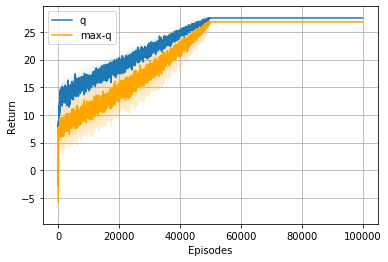

In [8]:
q_returns_over_runs = np.array(q_returns_over_runs)
print("Q-learning return for last 10 episodes for each of the 10 runs. Each row is a separate run: \n")
print(q_returns_over_runs[:,-10:])
mean = np.mean(q_returns_over_runs, axis=0)
std = np.std(q_returns_over_runs, axis=0)

plt.plot(episodes, mean, label = 'q')
plt.fill_between(episodes, mean+std, mean-std, alpha=0.2)

max_q_returns_over_runs = np.array(max_q_returns_over_runs)
print("\nMax-Q return for last 10 episodes for each of the 10 runs. Each row is a separate run: \n")
print(max_q_returns_over_runs[:,-10:])
mean = np.mean(max_q_returns_over_runs, axis=0)
std = np.std(max_q_returns_over_runs, axis=0)

print("\nComparison of average total reward i.e. return:")
plt.plot(episodes, mean, label = 'max-q', c='orange')
plt.fill_between(episodes, mean+std, mean-std, color='orange', alpha=0.2)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

#### Comparison of max episodic rewards i.e. max reward in episode

Q-learning max reward for last 10 episodes for each of the 10 runs. Each row is a separate run: 

[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]]
(10, 99971)

Max-Q max reward for last 10 episodes for each of the 10 runs. Each row is a separate run: 

[[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]

Comparison of average max reward over each episode:


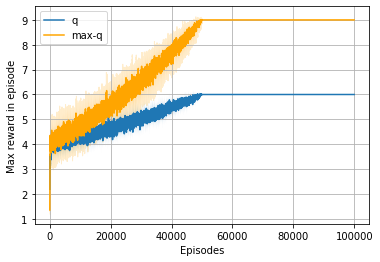

In [9]:
q_max_rewards_over_runs = np.array(q_max_rewards_over_runs)
print("Q-learning max reward for last 10 episodes for each of the 10 runs. Each row is a separate run: \n")
print(q_max_rewards_over_runs[:,-10:])
mean = np.mean(q_max_rewards_over_runs, axis=0)
std = np.std(q_max_rewards_over_runs, axis=0)

plt.plot(episodes, mean, label = 'q')
plt.fill_between(episodes, mean+std, mean-std, alpha=0.2)

max_q_max_rewards_over_runs = np.array(max_q_max_rewards_over_runs)
print(max_q_max_rewards_over_runs.shape)
print("\nMax-Q max reward for last 10 episodes for each of the 10 runs. Each row is a separate run: \n")
print(max_q_max_rewards_over_runs[:,-10:])
mean = np.mean(max_q_max_rewards_over_runs, axis=0)
std = np.std(max_q_max_rewards_over_runs, axis=0)

print("\nComparison of average max reward over each episode:")
plt.plot(episodes, mean, label = 'max-q', c='orange')
plt.fill_between(episodes, mean+std, mean-std, color='orange', alpha=0.2)
plt.xlabel("Episodes")
plt.ylabel("Max reward in episode")
plt.legend()
plt.grid()
plt.show()

#### Visualizing the learned policies


Final policy obtained with q-learning:


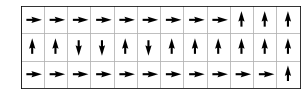

Final policy obtained with max-q:


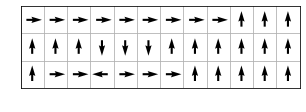

In [10]:
import warnings
warnings.filterwarnings('ignore')

q_learning_run_index = 1
max_q_learning_run_index = 1

print("\nFinal policy obtained with q-learning:")

arrow_dict = {'^': 1, 'v': -1, '>': 1, '<': -1}
X = np.array([np.arange(0, experiment['w'], 1).tolist()]*experiment['h']).astype(float)
Y = np.flip(np.transpose(np.array([np.arange(0, experiment['h'], 1).tolist()]*experiment['w'])), axis=0).astype(float)
U = np.zeros((experiment['h'], experiment['w']))
V = np.zeros((experiment['h'], experiment['w']))

U[q_final_policy_over_runs[q_learning_run_index] == '>'] = 1
U[q_final_policy_over_runs[q_learning_run_index] == '<'] = -1
V[q_final_policy_over_runs[q_learning_run_index] == '^'] = 1
V[q_final_policy_over_runs[q_learning_run_index] == 'v'] = -1
X[q_final_policy_over_runs[q_learning_run_index] == '>'] -= 0.25
X[q_final_policy_over_runs[q_learning_run_index] == '<'] += 0.25
Y[q_final_policy_over_runs[q_learning_run_index] == '>'] += 0.25
Y[q_final_policy_over_runs[q_learning_run_index] == '<'] += 0.25
Y[q_final_policy_over_runs[q_learning_run_index] == 'v'] += 0.5

plt.figure(figsize=(5,1.5))
plt.grid()
q = plt.quiver(X+0.5, Y+0.25, U, V)
#plt.axis('off')
plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
#plt.gca().axes.xaxis.set_ticks([])
for tic in plt.gca().axes.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
plt.ylim(0,experiment['h'])
plt.xlim(0,experiment['w'])
plt.show()

print("Final policy obtained with max-q:")

arrow_dict = {'^': 1, 'v': -1, '>': 1, '<': -1}
X = np.array([np.arange(0, experiment['w'], 1).tolist()]*experiment['h']).astype(float)
Y = np.flip(np.transpose(np.array([np.arange(0, experiment['h'], 1).tolist()]*experiment['w'])), axis=0).astype(float)
U = np.zeros((experiment['h'], experiment['w']))
V = np.zeros((experiment['h'], experiment['w']))

U[max_q_final_policy_over_runs[max_q_learning_run_index] == '>'] = 1
U[max_q_final_policy_over_runs[max_q_learning_run_index] == '<'] = -1
V[max_q_final_policy_over_runs[max_q_learning_run_index] == '^'] = 1
V[max_q_final_policy_over_runs[max_q_learning_run_index] == 'v'] = -1
X[max_q_final_policy_over_runs[max_q_learning_run_index] == '>'] -= 0.25
X[max_q_final_policy_over_runs[max_q_learning_run_index] == '<'] += 0.25
Y[max_q_final_policy_over_runs[max_q_learning_run_index] == '>'] += 0.25
Y[max_q_final_policy_over_runs[max_q_learning_run_index] == '<'] += 0.25
Y[max_q_final_policy_over_runs[max_q_learning_run_index] == 'v'] += 0.5

plt.figure(figsize=(5,1.5))
plt.grid()
q = plt.quiver(X+0.5, Y+0.25, U, V)
#plt.axis('off')
plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
#plt.gca().axes.xaxis.set_ticks([])
for tic in plt.gca().axes.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
plt.ylim(0,experiment['h'])
plt.xlim(0,experiment['w'])
plt.show()

#print(q_final_policy_over_runs[q_learning_run_index])
#print(max_q_final_policy_over_runs[max_q_learning_run_index])

#### Visualizing the learned q-values (both dominant and expected across the action dimension)


Visualizing the learned q values for q-learning


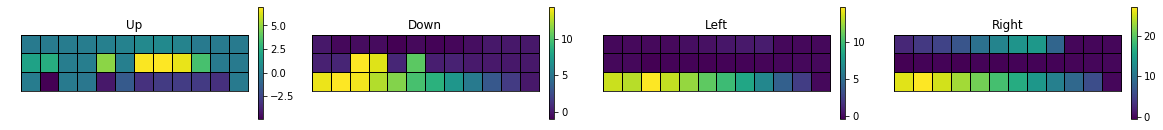


Visualizing the action wise maximum q values for q-learning


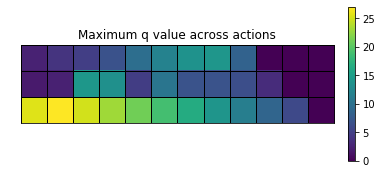

Visualizing the learned q values for max-q


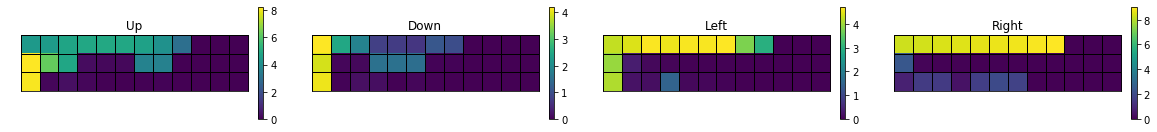


Visualizing the action wise maximum q values for max-q


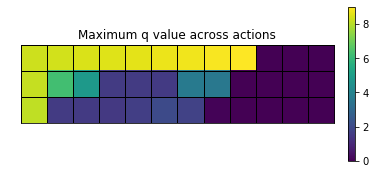

In [11]:
action_list = ['Up', 'Down', 'Left', 'Right']
q_learning_run_index = 1
max_q_learning_run_index = 1

print("\nVisualizing the learned q values for q-learning")
plt.figure(figsize=(20,5))
for i in range(4):
    q_vals_to_plot = q_final_q_values_over_runs[q_learning_run_index][:,i]
    q_vals_to_plot = np.flip(np.reshape(q_vals_to_plot, (experiment['h'], experiment['w'])), axis=0)
    plt.subplot(141+i)
    plt.title(action_list[i])
    plt.imshow(q_vals_to_plot)
    plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
    plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
    for tic in plt.gca().axes.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in plt.gca().axes.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    plt.gca().axes.set_xticks(np.arange(-.5, experiment['w'], 1), minor=True)
    plt.gca().axes.set_yticks(np.arange(-.5, experiment['h'], 1), minor=True)
    plt.grid(which='minor', color='k', linestyle='-', linewidth=1)
    for tic in plt.gca().axes.xaxis.get_minor_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in plt.gca().axes.yaxis.get_minor_ticks():
        tic.tick1On = tic.tick2On = False
    plt.colorbar(fraction=0.023, pad=0.04)
plt.show()

print("\nVisualizing the action wise maximum q values for q-learning")
q_vals_to_plot_max = np.max(q_final_q_values_over_runs[q_learning_run_index], axis=1)
q_vals_to_plot_max = np.flip(np.reshape(q_vals_to_plot_max, (experiment['h'], experiment['w'])), axis=0)
plt.title('Maximum q value across actions')
plt.imshow(q_vals_to_plot_max)
plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
for tic in plt.gca().axes.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
plt.gca().axes.set_xticks(np.arange(-.5, experiment['w'], 1), minor=True)
plt.gca().axes.set_yticks(np.arange(-.5, experiment['h'], 1), minor=True)
plt.grid(which='minor', color='k', linestyle='-', linewidth=1)
for tic in plt.gca().axes.xaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
plt.colorbar(fraction=0.023, pad=0.04)
plt.show()
    
plt.figure(figsize=(20,5))
print("Visualizing the learned q values for max-q")
for i in range(4):
    max_q_vals_to_plot = max_q_final_q_values_over_runs[max_q_learning_run_index][:,i]
    max_q_vals_to_plot = np.flip(np.reshape(max_q_vals_to_plot, (experiment['h'], experiment['w'])), axis=0)
    plt.subplot(141+i)
    plt.title(action_list[i])
    plt.imshow(max_q_vals_to_plot)
    plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
    plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
    for tic in plt.gca().axes.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in plt.gca().axes.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    plt.gca().axes.set_xticks(np.arange(-.5, experiment['w'], 1), minor=True)
    plt.gca().axes.set_yticks(np.arange(-.5, experiment['h'], 1), minor=True)
    plt.grid(which='minor', color='k', linestyle='-', linewidth=1)
    for tic in plt.gca().axes.xaxis.get_minor_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in plt.gca().axes.yaxis.get_minor_ticks():
        tic.tick1On = tic.tick2On = False
    plt.colorbar(fraction=0.023, pad=0.04)
plt.show()

print("\nVisualizing the action wise maximum q values for max-q")
max_q_vals_to_plot_max = np.max(max_q_final_q_values_over_runs[max_q_learning_run_index], axis=1)
max_q_vals_to_plot_max = np.flip(np.reshape(max_q_vals_to_plot_max, (experiment['h'], experiment['w'])), axis=0)
plt.title('Maximum q value across actions')
plt.imshow(max_q_vals_to_plot_max)
plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
for tic in plt.gca().axes.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
plt.gca().axes.set_xticks(np.arange(-.5, experiment['w'], 1), minor=True)
plt.gca().axes.set_yticks(np.arange(-.5, experiment['h'], 1), minor=True)
plt.grid(which='minor', color='k', linestyle='-', linewidth=1)
for tic in plt.gca().axes.xaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
plt.colorbar(fraction=0.023, pad=0.04)
plt.show()

#### Visualizing the environment i.e. reward structure, agent starting location etc.

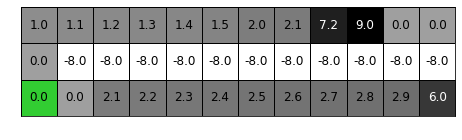

In [12]:
env_layout = np.flip(np.array([[ 1., 1.1, 1.2, 1.3, 1.4, 1.5, 2., 2.1, 7.2, 9., 0., 0.], 
                       [ 0., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.], 
                       [ 99, 0., 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 6.]]), axis=0)

plt.figure(figsize=(10,2))
#plt.imshow(env_layout, cmap='Greys')

value = 99
masked_array = np.ma.masked_where(env_layout == value, env_layout)
cmap = plt.cm.Greys
cmap.set_bad(color='limegreen')
plt.imshow(masked_array, cmap=cmap)

for (j,i),label in np.ndenumerate(env_layout):
    if j==2 and i in (8,9):
        plt.text(i,j,label,ha='center',va='center', c='w', weight = 'normal', size=12)
    elif j==0 and i==11:
        plt.text(i,j,label,ha='center',va='center', c='w', weight = 'normal', size=12)
    elif j==1 and i>0:
        plt.text(i,j,'-8.0',ha='center',va='center', c='k', weight = 'normal', size=12)
    elif j==0 and i==0:
        plt.text(i,j,'0.0',ha='center',va='center', c='k', weight = 'normal', size=12)
    else:
        plt.text(i,j,label,ha='center',va='center', c='k', weight = 'normal', size=12)

plt.xticks(ticks=np.arange(0, experiment['w'], 1), color='w')
plt.yticks(ticks=np.arange(0, experiment['h'], 1), color='w')
for tic in plt.gca().axes.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
plt.gca().axes.set_xticks(np.arange(-.5, experiment['w'], 1), minor=True)
plt.gca().axes.set_yticks(np.arange(-.5, experiment['h'], 1), minor=True)
plt.grid(which='minor', color='k', linestyle='-', linewidth=1)
for tic in plt.gca().axes.xaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
for tic in plt.gca().axes.yaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
plt.ylim(-0.5,experiment['h']-0.5)
plt.xlim(-0.5,experiment['w']-0.5)

plt.show()